In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet50, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
%matplotlib inline

In [77]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [78]:
train_gen = train_datagen.flow_from_directory(
        'cars/train',
        target_size=(150, 150),
        batch_size=8,
        class_mode='binary',
        shuffle=True)

Found 83 images belonging to 2 classes.


In [79]:
val_gen = val_datagen.flow_from_directory(
        'cars/val',
        target_size=(150, 150),
        batch_size=8,
        class_mode='binary',
        shuffle=False)

Found 46 images belonging to 2 classes.


In [80]:
test_gen = test_datagen.flow_from_directory(
        'cars/test',
        target_size=(150, 150),
        batch_size=8,
        class_mode='binary',
        shuffle=False)

Found 9 images belonging to 2 classes.


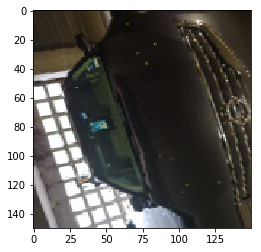

In [81]:
batch = train_gen.next()  # this will read in 32 images from the train directory
batch[0][0]               # this is one 150,150,3 color photo
batch[1][0]               # this is the one-hot encoded label for this photo
plt.imshow(batch[0][1])
plt.show()


IndexError: index 8 is out of bounds for axis 0 with size 8

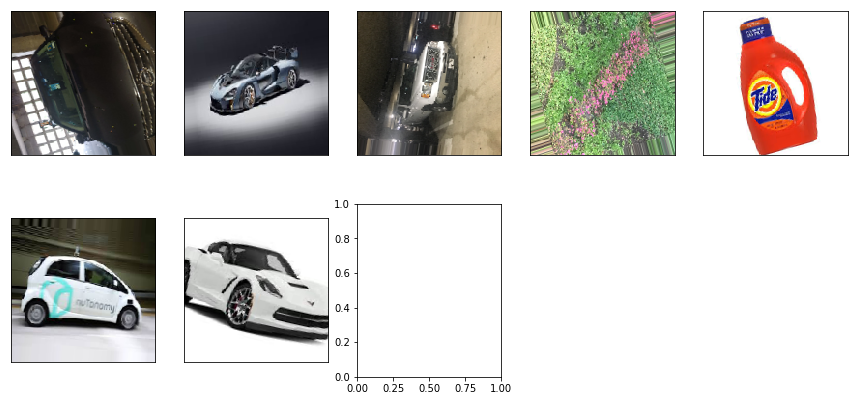

In [82]:
fig = plt.figure(figsize=(15,7))

for i in range(1,11):
    plt.subplot(2, 5, i)
    img = batch[0][i].squeeze()
    #label_ind = list(batch[1][i]).index(1)
    #plt.title(data[label_ind])
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [83]:
input_shape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='softmax'))

opt = optimizers.Nadam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 256)      

In [84]:
train_batches = int(train_gen.samples / train_gen.batch_size) * 2
val_batches = int(val_gen.samples / val_gen.batch_size)

history = model.fit_generator(
        generator=train_gen,
        validation_data=val_gen,
        verbose=1,
        epochs=5,
        steps_per_epoch=train_batches,
        validation_steps=val_batches
)

Epoch 1/5
20/20 [==============================] - 30s 2s/step - loss: 9.3971 - binary_accuracy: 0.3800 - val_loss: 9.5833 - val_binary_accuracy: 0.3750
Epoch 2/5
20/20 [==============================] - 27s 1s/step - loss: 9.2608 - binary_accuracy: 0.4000 - val_loss: 9.5833 - val_binary_accuracy: 0.3750
Epoch 3/5
20/20 [==============================] - 26s 1s/step - loss: 10.1902 - binary_accuracy: 0.3355 - val_loss: 9.5833 - val_binary_accuracy: 0.3750
Epoch 4/5
20/20 [==============================] - 15s 765ms/step - loss: 9.6764 - binary_accuracy: 0.3724 - val_loss: 9.5833 - val_binary_accuracy: 0.3750
Epoch 5/5
20/20 [==============================] - 25s 1s/step - loss: 9.4223 - binary_accuracy: 0.3871 - val_loss: 9.5833 - val_binary_accuracy: 0.3750


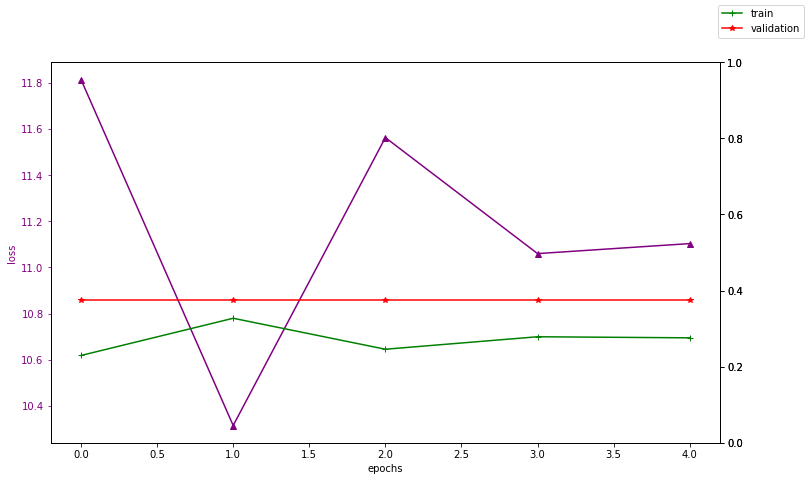

In [74]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(history.epoch, history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(history.epoch, history.history['binary_accuracy'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(history.epoch, history.history['val_binary_accuracy'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)

fig.legend();

In [75]:
model.evaluate_generator(test_gen)

[5.749964714050293, 0.33333334]